In [6]:
pip install skopt

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import os
import sys
import glob
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score



In [67]:
# 导入数据

data = pd.read_csv('input/final_data_input_important_16869.csv')
df= pd.DataFrame(data)
counts = df['label'].value_counts()
num_zeros = counts[0]
num_ones = counts[1]
print("number of zero:",num_zeros)
print("number of one:",num_ones)

df
# 对所有数据中的输入特征进行标准化
# 选择需要标准化的列
cols_to_normalize = df.columns[1:-1]

# 实例化StandardScaler对象
scaler = StandardScaler()

# 对需要标准化的列进行标准化
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

df


number of zero: 14402
number of one: 2466


,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750,1
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669,1
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833,1
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982,1
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136,1
...,...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347,0
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999,0
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731,0
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098,0


In [68]:
# 所有特征
all_features = df.iloc[:, 1:-1]
all_features_withFID = df.iloc[:, 0:-1] 
all_features_withFID



,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136
...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098


In [69]:
# 从总数据中抽取1000个1和1000个0作为训练和测试，剩下的作为预测集
# 随机抽取label为0和1的数据各1000个
df1 = pd.concat([df[df['label']==0].sample(n=1000),df[df['label']==1].sample(n=1000)]) # 训练集和测试集

# 删除已经抽取的数据，剩下的放入df2中
df2 = df.drop(df1.index) # 剩下的数据作为预测集
X_pred_withFID_ = df2.iloc[:, :-1] 
X_pred = df2.iloc[:, 1:-1]
X_pred_withFID_
Y_pred = df2.iloc[:, -1]


In [70]:
# 固定训练集、测试集、预测集，将其分别输出到CSV文件中
df1.to_csv('train_test_data.csv', index=False)
df2.to_csv('predict_data.csv', index=False)

In [71]:
# 用df1中的数据划分训练集和测试集，输出到CSV文件中
from sklearn.model_selection import train_test_split

# 提取最后一列并命名为“y”
X_withFID_ = df1.iloc[:, :-1] #训练加测试加FID
X = df1.iloc[:, 1:-1] # X不带FID
Y = df1.iloc[:, -1]


X_train_withFID, X_test_withFID, Y_train, Y_test = train_test_split(X_withFID_, Y, test_size=0.2, random_state=42)

X_train = X_train_withFID.iloc[:, 1:]
X_test = X_test_withFID.iloc[:, 1:]

# 输出训练集和测试集
X_train_Y_train_withFID = pd.concat([X_train_withFID, Y_train],axis=1)
X_test_Y_test_withFID = pd.concat([X_test_withFID, Y_test],axis=1)
X_pred_Y_pred_withFID = pd.concat([X_pred_withFID_, Y_pred],axis=1)

X_train_Y_train_withFID.to_csv('train_data_FID.csv', index=False)
X_test_Y_test_withFID.to_csv('test_data_FID.csv', index=False)
X_pred_Y_pred_withFID.to_csv('predict_data_FID.csv', index=False)



In [72]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print(pd.value_counts(Y_train))

print(pd.value_counts(Y_test))

(1600, 7) (400, 7) (1600,) (400,)
label
0    801
1    799
Name: count, dtype: int64
label
1    201
0    199
Name: count, dtype: int64


In [73]:
def print_test_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def print_train_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_train) == Y_train)/len(Y_train)))
    time.sleep(0.5) # to let the print get out before any progress bars
shap.initjs()

In [74]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 将数据分为X_train, Y_train, X_test, Y_test

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier()

# 定义参数空间
param_grid = {
    'max_depth': [3, 4, 6, 8,10],
    'learning_rate': [0.5,0.1, 0.01],
    'min_child_weight': [1, 3, 5,7,10],
    # 'subsample': [0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1],
    'gamma': [0, 0.1,0.3, 0.5],
    'n_estimators': [50, 100],
}

# 定义5折交叉验证策略
cv = StratifiedKFold(n_splits=5)

# 使用GridSearchCV进行自动调参和交叉验证
grid_search_xgb = GridSearchCV(xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1)

grid_search_xgb.fit(X_train, Y_train)

# 输出每一折的训练集和测试集准确率
for i in range(5):
    train_index, test_index = list(cv.split(X_train, Y_train))[i]

# 计算ROC曲线和AUC曲线
fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_xgb.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_xgb.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

In [75]:
# 用网格搜索到的最优参数重新训练模型
params_xgb =grid_search_xgb.best_params_
best_params_xgb = xgb.XGBClassifier(**params_xgb)
best_params_xgb.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [76]:
# nn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 定义多层感知机模型
mlp = MLPClassifier()

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.1],
    'learning_rate': ['constant', 'adaptive']
}

# 定义5折交叉验证器
cv = StratifiedKFold(n_splits=5)

# 定义网格搜索器
grid_search_mlp = GridSearchCV(mlp, param_grid=param_grid,
                           cv=cv, scoring='roc_auc')

# 训练模型并进行自动调参
grid_search_mlp.fit(X_train, Y_train)

# 输出最佳参数组合和对应的AUC值
print('Best parameters:', grid_search_mlp.best_params_)
print('Best AUC:', grid_search_mlp.best_score_)

# 计算模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线等指标，并打印结果
Y_train_pred = grid_search_mlp.predict(X_train)
Y_test_pred = grid_search_mlp.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_mlp.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_mlp.predict_proba(X_test)[:, 1])


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Opt

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best AUC: 0.8579519845135553


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [77]:
# 用网格搜索到的nn最优参数重新训练模型

params_mlp = grid_search_mlp.best_params_
best_params_mlp = MLPClassifier(**params_mlp)
best_params_mlp.fit(X_train, Y_train)



Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


MLPClassifier(alpha=0.1, hidden_layer_sizes=(10,), learning_rate='adaptive')

In [78]:
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd

# 定义逻辑回归模型和参数网格
model = LogisticRegression()
param_grid = {'C': [ 0.01, 0.1,0.5,1]}

# 使用GridSearchCV进行自动调参和5折交叉验证
grid_search_lr = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, Y_train)


# 绘制ROC曲线和计算AUC
fpr, tpr, thresholds = roc_curve(Y_test, grid_search_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [79]:
params_lr = grid_search_lr.best_params_
best_params_lr =  LogisticRegression(**params_lr)
best_params_lr.fit(X_train, Y_train)


LogisticRegression(C=1)

比较三个代表性模型的性能，如果相差很大，那就不用再加RF, SVM,如果相差不大，加上。
多个模型和多个可解释性的比较分析，用预测正确的结果进行可解释性分析。


In [80]:
# 将LR, XGB, NN的模型性能进行对比

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

# 训练三个机器学习模型并预测测试集
model_lr = best_params_lr
model_xgb = best_params_xgb
model_mlp = best_params_mlp

Y_test_pred1 = model_lr.predict(X_test)
Y_test_pred2 = model_xgb.predict(X_test)
Y_test_pred3 = model_mlp.predict(X_test)

# 计算评价指标
accuracy_train1 = accuracy_score(Y_train, model_lr.predict(X_train))
accuracy_train2 = accuracy_score(Y_train, model_xgb.predict(X_train))
accuracy_train3 = accuracy_score(Y_train, model_mlp.predict(X_train))

accuracy_test1 = accuracy_score(Y_test, model_lr.predict(X_test))
accuracy_test2 = accuracy_score(Y_test, model_xgb.predict(X_test))
accuracy_test3 = accuracy_score(Y_test, model_mlp.predict(X_test))

precision_train1 = precision_score(Y_train, model_lr.predict(X_train))
precision_train2 = precision_score(Y_train, model_xgb.predict(X_train))
precision_train3 = precision_score(Y_train, model_mlp.predict(X_train))

precision_test1 = precision_score(Y_test, Y_test_pred1)
precision_test2 = precision_score(Y_test, Y_test_pred2)
precision_test3 = precision_score(Y_test, Y_test_pred3)

recall_train1 = recall_score(Y_train, model_lr.predict(X_train))
recall_train2 = recall_score(Y_train, model_xgb.predict(X_train))
recall_train3 = recall_score(Y_train, model_mlp.predict(X_train))

recall_test1 = recall_score(Y_test, Y_test_pred1)
recall_test2 = recall_score(Y_test, Y_test_pred2)
recall_test3 = recall_score(Y_test, Y_test_pred3)

f1score_train1 = f1_score(Y_train, model_lr.predict(X_train))
f1score_train2 = f1_score(Y_train, model_xgb.predict(X_train))
f1score_train3 = f1_score(Y_train, model_mlp.predict(X_train))

f1score_test1 = f1_score(Y_test, Y_test_pred1)
f1score_test2 = f1_score(Y_test, Y_test_pred2)
f1score_test3 = f1_score(Y_test, Y_test_pred3)

# 将评价指标存储在字典中
results_train = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (train)': [accuracy_train1, accuracy_train2, accuracy_train3],
    'Precision (train)': [precision_train1, precision_train2, precision_train3],
    'Recall (train)': [recall_train1, recall_train2, recall_train3],
    'F1 score (train)': [f1score_train1, f1score_train2, f1score_train3],
}
results_test = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (test)': [accuracy_test1, accuracy_test2, accuracy_test3],
    'Precision (test)': [precision_test1, precision_test2, precision_test3],
    'Recall (test)': [recall_test1, recall_test2, recall_test3],
    'F1 score (test)': [f1score_test1, f1score_test2, f1score_test3],
}
# 将字典转换为 Pandas 数据框
df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)


In [81]:
df_results_train

,Model,Accuracy (train),Precision (train),Recall (train),F1 score (train)
0,Model_lr,0.783750,0.801598,0.753442,0.776774
1,Model_xgb,0.996875,0.993781,1.000000,0.996881
2,Model_mlp,0.789375,0.800000,0.770964,0.785214


In [82]:
df_results_test

,Model,Accuracy (test),Precision (test),Recall (test),F1 score (test)
0,Model_lr,0.7750,0.776119,0.776119,0.776119
1,Model_xgb,0.7500,0.753769,0.746269,0.750000
2,Model_mlp,0.7725,0.764423,0.791045,0.777506


xgb_loss 0.5838362380255353
linear_loss 0.510840776098945
dnn_loss 8.199931146024152

xgb_roc_auc 0.8458711467786695
linear_roc_auc 0.8454461361534038
dnn_roc_auc 0.7724068101702541

xgb_pr_auc 0.8452383899223199
linear_pr_auc 0.8344668772723396
dnn_pr_auc 0.7096928817451205



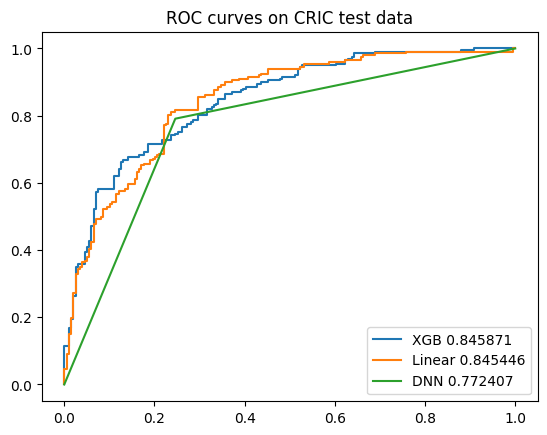

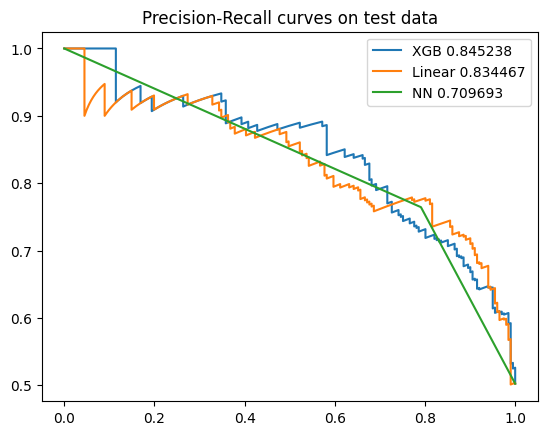

In [83]:
# Compute performance metrics
Y_test1 = Y_test.ravel() # 将Y_test1转换为一维数组
xgb_loss = sklearn.metrics.log_loss(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(Y_test1, model_lr.predict_proba(X_test)[:,1])
nn_loss = sklearn.metrics.log_loss(Y_test1, model_mlp.predict(X_test))
# constant_loss = sklearn.metrics.log_loss(Y_test1, np.zeros(len(Y_test1)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", nn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_mlp.predict(X_test))
#svm_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
#print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_mlp.predict(X_test))
#svm_pr_auc = sklearn.metrics.average_precision_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
#print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_mlp.predict(X_test))
#svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, svm_model.predict_proba(X_test))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
#pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_mlp.predict(X_test))
#svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, svm_model.predict_proba(X_test))

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="NN %f" % dnn_pr_auc)
#pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on test data")
pl.show()

In [84]:
# 用训练好的模型和所有预测正确的样本进行模型可解释性分析

# 训练好的模型

# 所有预测正确的样本


### 将三个模型预测准确的样本选出来分别放入一个样本集中，用于后续可解释性方法对比分析
1. 用训练好的模型预测剩余样本
2. 将所有样本（训练集、测试集、预测集）预测概率与是否预测正确输出，并于样本编号匹配
3. 挑选出预测正确的样本
4. 用不同可解释性方法对不同模型预测正确的样本进行可解释性分析

In [86]:
# 将训练、测试、预测结果与输入一起保存到output文件中
# 训练集
output_train_lr = pd.concat([X_train_withFID, Y_train, pd.Series(model_lr.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
outpt_train_xgb = pd.concat([X_train_withFID, Y_train, pd.Series(model_xgb.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_train_mlp = pd.concat([X_train_withFID, Y_train, pd.Series(model_mlp.predict_proba(X_train)[:,1], index=X_train_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 测试集
output_test_lr = pd.concat([X_test_withFID, Y_test, pd.Series(model_lr.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_xgb = pd.concat([X_test_withFID, Y_test, pd.Series(model_xgb.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_mlp = pd.concat([X_test_withFID, Y_test, pd.Series(model_mlp.predict_proba(X_test)[:,1], index=X_test_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 预测集
output_pred_lr = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_lr.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_xgb = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_xgb.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_mlp = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_mlp.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index, name='probability_1')], axis=1) # 保留预测为1的概率


# predicted列为预测结果，0为未被淹，1为被淹
# 训练集
output_train_lr['predicted'] = (output_train_lr['probability_1'] >= 0.5).astype(int)
outpt_train_xgb['predicted'] = (outpt_train_xgb['probability_1'] >= 0.5).astype(int)
output_train_mlp['predicted'] = (output_train_mlp['probability_1'] >= 0.5).astype(int)

# 测试集
output_test_lr['predicted'] = (output_test_lr['probability_1'] >= 0.5).astype(int)
output_test_xgb['predicted'] = (output_test_xgb['probability_1'] >= 0.5).astype(int)
output_test_mlp['predicted'] = (output_test_mlp['probability_1'] >= 0.5).astype(int)

# 预测集
output_pred_lr['predicted'] = (output_pred_lr['probability_1'] >= 0.5).astype(int)
output_pred_xgb['predicted'] = (output_pred_xgb['probability_1'] >= 0.5).astype(int)
output_pred_mlp['predicted'] = (output_pred_mlp['probability_1'] >= 0.5).astype(int)


# 判断预测是否正确
# 训练集
output_train_lr['correct'] = (output_train_lr['predicted'] == output_train_lr['label']).astype(int)
outpt_train_xgb['correct'] = (outpt_train_xgb['predicted'] == outpt_train_xgb['label']).astype(int)
output_train_mlp['correct'] = (output_train_mlp['predicted'] == output_train_mlp['label']).astype(int)

# 测试集
output_test_lr['correct'] = (output_test_lr['predicted'] == output_test_lr['label']).astype(int)
output_test_xgb['correct'] = (output_test_xgb['predicted'] == output_test_xgb['label']).astype(int)
output_test_mlp['correct'] = (output_test_mlp['predicted'] == output_test_mlp['label']).astype(int)

# 预测集
output_pred_lr['correct'] = (output_pred_lr['predicted'] == output_pred_lr['label']).astype(int)
output_pred_xgb['correct'] = (output_pred_xgb['predicted'] == output_pred_xgb['label']).astype(int)
output_pred_mlp['correct'] = (output_pred_mlp['predicted'] == output_pred_mlp['label']).astype(int)

# 将预测正确的样本保存在output文件中
# 训练集
output_train_lr_correct = output_train_lr[output_train_lr['correct'] == 1]
outpt_train_xgb_correct = outpt_train_xgb[outpt_train_xgb['correct'] == 1]
output_train_mlp_correct = output_train_mlp[output_train_mlp['correct'] == 1]

# 测试集
output_test_lr_correct = output_test_lr[output_test_lr['correct'] == 1]
output_test_xgb_correct = output_test_xgb[output_test_xgb['correct'] == 1]
output_test_mlp_correct = output_test_mlp[output_test_mlp['correct'] == 1]

# 预测集
output_pred_lr_correct = output_pred_lr[output_pred_lr['correct'] == 1]
output_pred_xgb_correct = output_pred_xgb[output_pred_xgb['correct'] == 1]
output_pred_mlp_correct = output_pred_mlp[output_pred_mlp['correct'] == 1]

# 保存到CSV文件中
# 测试集
output_train_lr_correct.to_csv('output/output_train_lr_correct.csv', index=False)
outpt_train_xgb_correct.to_csv('output/output_train_xgb_correct.csv', index=False)
output_train_mlp_correct.to_csv('output/output_train_mlp_correct.csv', index=False)

# 测试集
output_test_lr_correct.to_csv('output/output_test_lr_correct.csv', index=False)
output_test_xgb_correct.to_csv('output/output_test_xgb_correct.csv', index=False)
output_test_mlp_correct.to_csv('output/output_test_mlp_correct.csv', index=False)

# 预测集
output_pred_lr_correct.to_csv('output/output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct.to_csv('output/output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct.to_csv('output/output_pred_mlp_correct.csv', index=False)

# 将测试集、训练集、预测集结果预测正确的样本保存在一个文件中
output_pred_lr_correct_all = pd.concat([output_train_lr_correct, output_test_lr_correct, output_pred_lr_correct], axis=0)
output_pred_xgb_correct_all = pd.concat([outpt_train_xgb_correct, output_test_xgb_correct, output_pred_xgb_correct], axis=0)
output_pred_mlp_correct_all = pd.concat([output_train_mlp_correct, output_test_mlp_correct, output_pred_mlp_correct], axis=0)

# 保存到CSV文件中
output_pred_lr_correct_all.to_csv('output/all_output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct_all.to_csv('output/all_output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct_all.to_csv('output/all_output_pred_mlp_correct.csv', index=False)




### 对不同模型预测错误的结果也可以用SHAP进行进一步分析


In [35]:
import lime.lime_tabular
X = ['average_max_rainfall',	'average_2hr_rainfall',	'average_72hr_rainfall',	'distance to coast',	'EV',	'TWI',	'DTW']
X_values = output_test_pred_lr.iloc[:, 1:-4]
# 测试集和预测集的预测结果
# Initialize SHAP explainer
explainer = shap.Explainer(model_lr.predict_proba, output_test_pred_lr.iloc[:, 1:-4])

# Compute SHAP values for LR model
shap_values_lr = explainer(output_test_pred_lr.iloc[:, 1:-4])

# Initialize LIME explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_values, feature_names=X, class_names=['0', '1'])

# Compute LIME explanations for LR model
lime_explanations_lr = []
for i in range(len(output_test_pred_lr.iloc[:, 1:-4])):
    exp = explainer_lime.explain_instance(output_test_pred_lr.iloc[:, 1:-4].values[i], model_xgb.predict_proba)
    lime_explanations_lr.append(exp.as_list())

# Repeat for XGBoost and MLP models

# Compare SHAP and LIME explanations for LR model
print('SHAP values for LR model:')
print(shap_values_lr)
print('LIME explanations for LR model:')
print(lime_explanations_lr)

Exact explainer: 15269it [00:42, 266.38it/s]                           


InvalidIndexError: (slice(None, None, None), 0)

为什么把预测正确的结果挑出来进行解释，结果就很不理想呢？

可能是因为SHAP方法的解释是基于模型的预测结果和特征值之间的关系，而不是仅仅基于特征值本身。如果您将一个机器学习模型预测正确的样本特征输入到SHAP方法中，它可能会显示一些与您预期不同的结果，因为该样本已经被正确分类了，所以该样本对于模型的输出没有太大影响。因此，SHAP值可能会显示较小或负数，这可能会导致看起来奇怪或不符合直觉。

另外，请注意，在使用SHAP方法时，应该使用测试集中未被训练过的样本进行解释。如果您使用训练集中的样本进行解释，则可能会出现过拟合问题，并且解释结果可能无法泛化到新数据上。
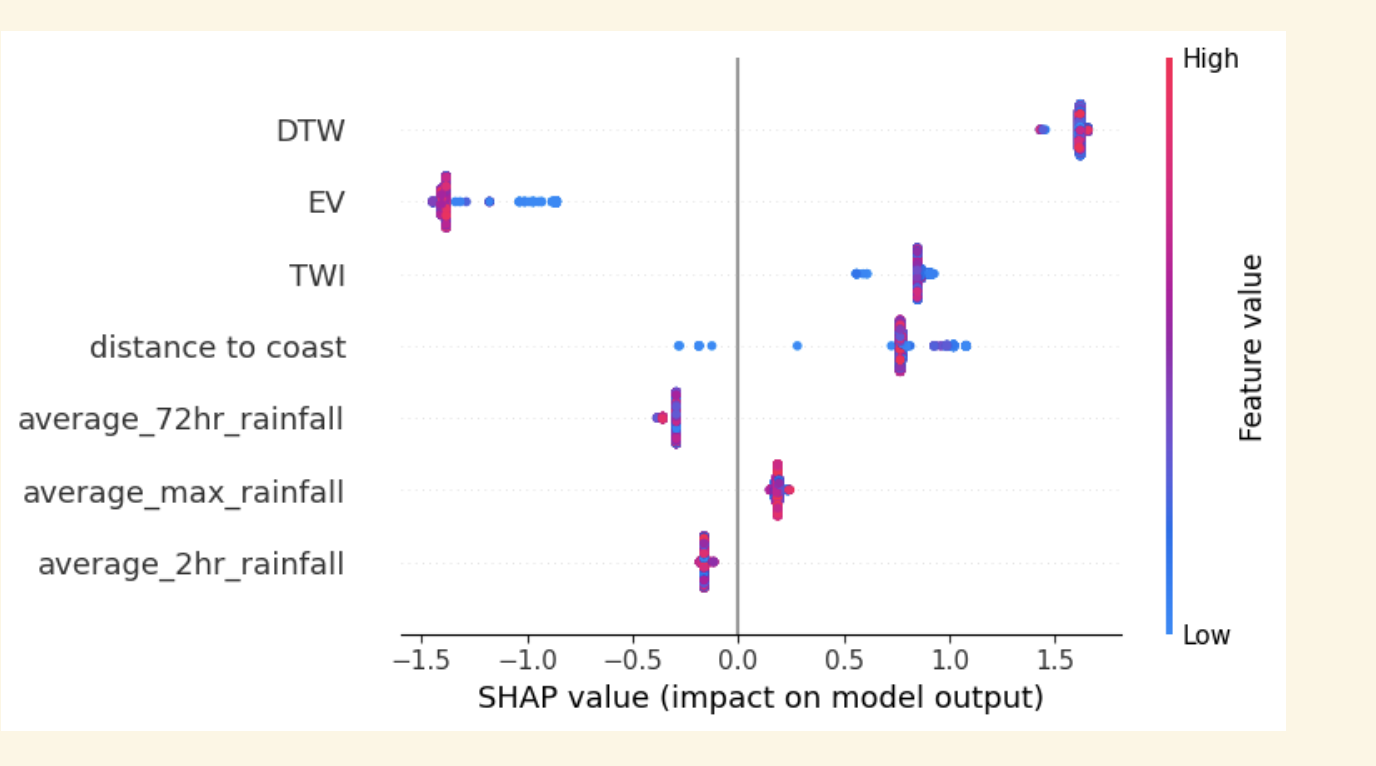

SHAP方法可以用于训练集和测试集上，以帮助解释模型的预测结果。在训练集上使用SHAP方法可以帮助了解模型是如何学习特征的，而在测试集上使用SHAP方法可以帮助了解模型如何对新数据进行预测。但是，为了避免过拟合问题，应该在测试集中使用未被训练过的样本进行解释，并且不应该将测试集中的解释结果用于调整模型。

预测集通常是指未被标记的新数据，因此在预测阶段使用SHAP方法可以帮助了解模型如何对新数据进行预测，并且可以提供有关每个特征对于每个预测的贡献程度的信息。

如果模型的预测结果出现错误，可以使用SHAP方法来帮助诊断问题并找出导致错误的原因。通过分析每个特征对于预测结果的贡献程度，可以确定哪些特征可能导致了错误的预测结果。然后可以进一步分析这些特征是否存在问题，例如数据质量问题或者特征工程问题，并尝试解决这些问题以提高模型的准确性。

此外，还可以使用SHAP方法来比较不同模型之间的预测结果，并找出哪些模型在哪些方面表现更好或更差。这可以帮助选择最佳模型并进行进一步改进。



In [ ]:
# 将所有训练集的样本预测后进行解释，可以知道模型是如何学习特征的。
# 在测试集上预测集上的样本进行解释，可以知道模型是如何进行预测的。
# 挑出来不同模型预测正确和错误的样本，可以知道不同模型的差异性，不同模型在哪些方法表现更好或更差。

In [ ]:
# 在进行单个解释的时候挑选那些预测正确的特征


In [49]:
# 训练集
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
16168,0.542365,0.262815,1.798293,1.640617,-0.929318,0.314495,1.253643
16609,1.118440,0.781058,0.514703,-0.790291,4.428628,-0.158744,-1.887860
761,1.009012,0.976183,-1.204919,2.053555,1.772111,1.610993,-1.190815
7682,1.179371,-1.644905,-1.026334,1.854903,0.624029,0.666867,-0.697095
15244,-1.590422,-0.850295,0.007985,-0.012780,0.148409,1.146442,-0.487036
...,...,...,...,...,...,...,...
11225,-0.465550,-0.162854,0.224214,-0.105319,-0.702659,0.937778,-0.417440
14496,-1.666668,2.823878,1.691797,-1.091707,-0.480397,-0.788933,-0.042040
483,-1.469324,2.206787,0.429568,-1.051283,0.492067,-0.688756,-0.704439
14483,0.722011,-0.964785,0.574894,0.808661,0.842150,-0.701629,-0.686261


In [50]:
# 测试集
X_test

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
9137,-0.412546,0.446959,0.338186,0.738533,0.608572,1.822953,0.523177
12085,0.549086,0.121867,0.846960,0.877177,0.662536,0.799382,-0.183241
9527,1.403300,-1.899089,-0.985753,1.400106,0.360776,-0.721301,1.795164
15026,0.536259,-0.576018,0.750649,0.912810,0.599680,-0.171884,1.292999
34,-0.874222,1.420642,-0.137280,-0.373577,0.759689,0.419161,-0.402943
...,...,...,...,...,...,...,...
2162,-1.912733,1.681117,0.258697,-0.917116,-0.424840,-0.543584,-1.124962
628,0.703741,0.927872,-1.088753,1.862614,0.932023,1.112975,1.706131
4533,0.428661,-0.279715,-0.769326,-0.835135,-0.558541,-1.021836,-0.991118
11479,0.193554,0.375166,0.371660,0.318972,0.548406,1.489530,0.308005


In [48]:
# 预测集
X_pred= df2.iloc[:, 1:-1]
X_pred

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
2,1.034249,0.173900,0.540413,1427.899396,3.355286,2170.271564,7.548316
4,1.038104,0.173915,0.539721,1472.312893,3.421316,2262.551560,9.006661
5,1.031257,0.173902,0.540960,1400.698530,3.587869,1970.089000,5.458872
6,1.030895,0.173901,0.541029,1386.608351,3.564653,1922.199779,6.266657
7,1.030442,0.173909,0.541106,1389.506261,3.703773,1914.187620,5.250920
...,...,...,...,...,...,...,...
16863,0.973075,0.173802,0.558195,288.711012,2.471787,995.830005,5.545090
16864,0.972212,0.173765,0.558101,301.895848,2.573513,1024.210310,7.424834
16865,0.974931,0.173857,0.558490,242.731595,2.150453,890.199884,6.642009
16866,0.976530,0.173897,0.558775,224.446030,2.170294,786.371904,6.314220


In [51]:
output_train_lr_correct

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label,probability_1,predicted,correct
16609,17206,1.065116,0.172907,0.568351,240.627186,7.081359,934.818043,3.475388,0,0.000655,0,1
761,774,1.059247,0.174222,0.536933,1389.409164,4.396524,2362.055838,4.411324,0,0.159314,0,1
7682,7908,1.068384,0.156558,0.540196,1309.162922,3.236204,1600.647758,5.074252,0,0.492736,0,1
15244,15754,0.919835,0.161913,0.559093,554.705502,2.755514,1987.409505,5.356301,0,0.245560,0,1
147,151,1.042467,0.173913,0.539101,1395.399543,3.490151,2209.234398,8.146758,1,0.898275,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5826,6008,0.979164,0.173230,0.563427,92.590694,1.056853,326.978409,5.046056,1,0.577020,1,1
5411,5566,0.937575,0.168541,0.555234,12.049212,0.678107,52.729231,6.084807,1,0.791029,1,1
8843,9086,0.940826,0.164254,0.552393,1130.525964,2.789525,2679.735380,6.653791,1,0.677485,1,1
11225,11536,0.980164,0.166546,0.563044,517.324132,1.895374,1819.129031,5.449750,1,0.555028,1,1


In [58]:
# 对特征输入进行标准化

scaler = StandardScaler()
output_train_lr_correct_scaled = scaler.fit_transform(output_train_lr_correct.iloc[:, 1:-4])

# 转化为DataFrame
output_train_lr_correct_scaled = pd.DataFrame(output_train_lr_correct_scaled, columns=output_train_lr_correct.iloc[:, 1:-4].columns)
output_train_lr_correct_scaled 

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,1.086166,0.792590,0.488452,-0.790520,4.248839,-0.147457,-1.832433
1,0.976134,0.990801,-1.214774,2.058019,1.700320,1.680462,-1.166227
2,1.147434,-1.671744,-1.037891,1.859039,0.598913,0.705297,-0.694350
3,-1.637653,-0.864566,-0.013434,-0.011726,0.142629,1.200638,-0.493585
4,0.661525,0.944295,-1.097249,2.072873,0.839966,1.484738,1.492683
...,...,...,...,...,...,...,...
1219,-0.525307,0.841300,0.221503,-1.157594,-1.469786,-0.925941,-0.714419
1220,-1.305055,0.134488,-0.222670,-1.357306,-1.829302,-1.277182,0.024971
1221,-1.244097,-0.511717,-0.376669,1.416088,0.174913,2.087326,0.429979
1222,-0.506571,-0.166251,0.200733,-0.104418,-0.673840,0.985114,-0.427067


In [62]:
# 对特征输入进行标准化

scaler = StandardScaler()
output_train_lr_scaled = scaler.fit_transform(output_train_lr.iloc[:, 1:-4])

# 转化为DataFrame
output__correct_scaled = pd.DataFrame(output_train_lr_scaled, columns=output_train_lr.iloc[:, 1:-4].columns)
output_train_lr

,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label,probability_1,predicted,correct
16168,16725,1.034220,0.169414,0.591802,1222.601212,1.666299,1316.470621,7.693545,0,0.935964,1,0
16609,17206,1.065116,0.172907,0.568351,240.627186,7.081359,934.818043,3.475388,0,0.000655,0,1
761,774,1.059247,0.174222,0.536933,1389.409164,4.396524,2362.055838,4.411324,0,0.159314,0,1
7682,7908,1.068384,0.156558,0.540196,1309.162922,3.236204,1600.647758,5.074252,0,0.492736,0,1
15244,15754,0.919835,0.161913,0.559093,554.705502,2.755514,1987.409505,5.356301,0,0.245560,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11225,11536,0.980164,0.166546,0.563044,517.324132,1.895374,1819.129031,5.449750,1,0.555028,1,1
14496,14976,0.915746,0.186673,0.589857,118.869311,2.120005,426.590594,5.953807,1,0.271667,0,0
483,492,0.926330,0.182515,0.566796,135.198575,3.102836,507.380320,5.064391,0,0.086614,0,1
14483,14961,1.043855,0.161142,0.569451,886.529467,3.456650,496.998419,5.088798,1,0.187988,0,0


In [60]:
X_train

,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
16168,0.542365,0.262815,1.798293,1.640617,-0.929318,0.314495,1.253643
16609,1.118440,0.781058,0.514703,-0.790291,4.428628,-0.158744,-1.887860
761,1.009012,0.976183,-1.204919,2.053555,1.772111,1.610993,-1.190815
7682,1.179371,-1.644905,-1.026334,1.854903,0.624029,0.666867,-0.697095
15244,-1.590422,-0.850295,0.007985,-0.012780,0.148409,1.146442,-0.487036
...,...,...,...,...,...,...,...
11225,-0.465550,-0.162854,0.224214,-0.105319,-0.702659,0.937778,-0.417440
14496,-1.666668,2.823878,1.691797,-1.091707,-0.480397,-0.788933,-0.042040
483,-1.469324,2.206787,0.429568,-1.051283,0.492067,-0.688756,-0.704439
14483,0.722011,-0.964785,0.574894,0.808661,0.842150,-0.701629,-0.686261


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


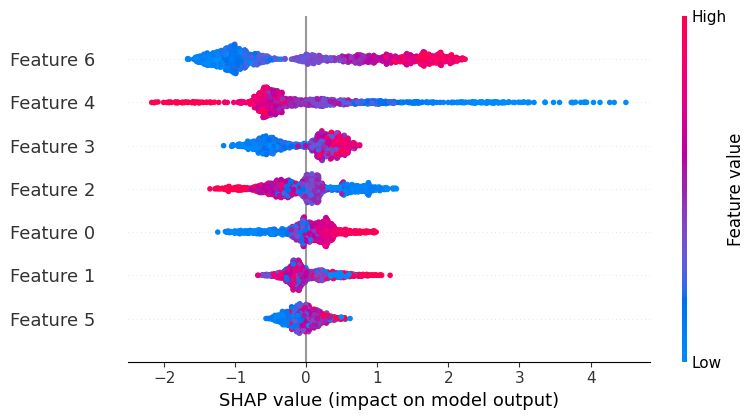

In [56]:
# TREESHAP

# 初始化SHAP解释器并计算特征重要性，在预测集上分析
explainer = shap.Explainer(model_xgb)
shap_values = explainer(output_train_lr_correct_scaled)

# 绘制汇总图表显示每个特征的重要性
shap.summary_plot(shap_values, output_train_lr_correct_scaled)

# 指标1 runtime 解释1000个预测样本所需的时间

# 指标2 local accuracy 1000个样本中，与模型输出的差异的归一化标准偏差

# 指标3 Consistency guarantees 一致性保证是解释方法的一个理论属性，它确保成对的案例永远一致（属性2）。我们把对这一属性的同意分成三个不同的类别：确切的保证、在无限抽样情况下成立的保证和没有保证。

# 指标4 Keep positive (mask) 指标衡量的是解释方法找到使模型输出增加最多的特征的能力。增加模型输出最多的特征。对于一个单一的输入，最积极的输入特征被保留在它们的原始值上，而所有其他的输入特征被掩盖在它们的平均值上。
# github库 Captum


In [60]:

model_xgb2 = xgboost.XGBClassifier(grid_search_xgb.best_params_)
model_xgb2.fit(X_train, Y_train)

shap_values = shap.TreeExplainer(model_xgb2).shap_values(X_train)
shap.summary_plot(shap_values, X_train)



Pass `objective` as keyword args.


XGBoostError: [12:44:09] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/objective.cc:26: Unknown objective function: `{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001740edbc8 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001742480dc xgboost::ObjFunction::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, xgboost::GenericParameter const*) + 556
  [bt] (2) 3   libxgboost.dylib                    0x00000001741f92c4 xgboost::LearnerConfiguration::ConfigureObjective(xgboost::LearnerTrainParam const&, std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > >*) + 1396
  [bt] (3) 4   libxgboost.dylib                    0x00000001741ee188 xgboost::LearnerConfiguration::Configure() + 1080
  [bt] (4) 5   libxgboost.dylib                    0x00000001741ee4cc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 128
  [bt] (5) 6   libxgboost.dylib                    0x0000000174107418 XGBoosterUpdateOneIter + 144
  [bt] (6) 7   libffi.dylib                        0x00000001b0d28050 ffi_call_SYSV + 80
  [bt] (7) 8   libffi.dylib                        0x00000001b0d30af4 ffi_call_int + 1208
  [bt] (8) 9   _ctypes.cpython-310-darwin.so       0x0000000102bd82a8 _ctypes_callproc + 1396



In [ ]:
# KernelSHAP

In [ ]:
# Individual Conditional Expectation (ICE) https://github.com/AustinRochford/PyCEbox

In [ ]:
# Counterfactual Explanations https://github.com/interpretml/DiCE

In [ ]:
# LIME GitHub代码找到 https://github.com/marcotcr/lime

In [ ]:
# saabas可以加上,nmL那篇文章都加了，我们也可以加，https://github.com/andosa/treeinterpreter
